# Исследование объявлений о продаже квартир

В вашем распоряжении данные сервиса Яндекс.Недвижимость — архив объявлений о продаже квартир в Санкт-Петербурге и соседних населённых пунктов за несколько лет. Нужно научиться определять рыночную стоимость объектов недвижимости.  

Наша задача - провести исследовательский анализ данных, который поможет установить параметры, влияющие на цену объектов. 

По каждой квартире на продажу доступны два вида данных. Первые вписаны пользователем, вторые — получены автоматически на основе картографических данных. Например, расстояние до центра, аэропорта, ближайшего парка и водоёма. 

## Откройте файл с данными и изучите общую информацию. 

In [123]:
import matplotlib.pyplot as plt
import pandas as pd

In [124]:
pd.set_option('display.max_columns', None)
data_raw = pd.read_csv('real_estate_data.csv', sep='\t')
data = data_raw.copy()

In [125]:
data_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   total_images          23699 non-null  int64  
 1   last_price            23699 non-null  float64
 2   total_area            23699 non-null  float64
 3   first_day_exposition  23699 non-null  object 
 4   rooms                 23699 non-null  int64  
 5   ceiling_height        14504 non-null  float64
 6   floors_total          23613 non-null  float64
 7   living_area           21796 non-null  float64
 8   floor                 23699 non-null  int64  
 9   is_apartment          2775 non-null   object 
 10  studio                23699 non-null  bool   
 11  open_plan             23699 non-null  bool   
 12  kitchen_area          21421 non-null  float64
 13  balcony               12180 non-null  float64
 14  locality_name         23650 non-null  object 
 15  airports_nearest   

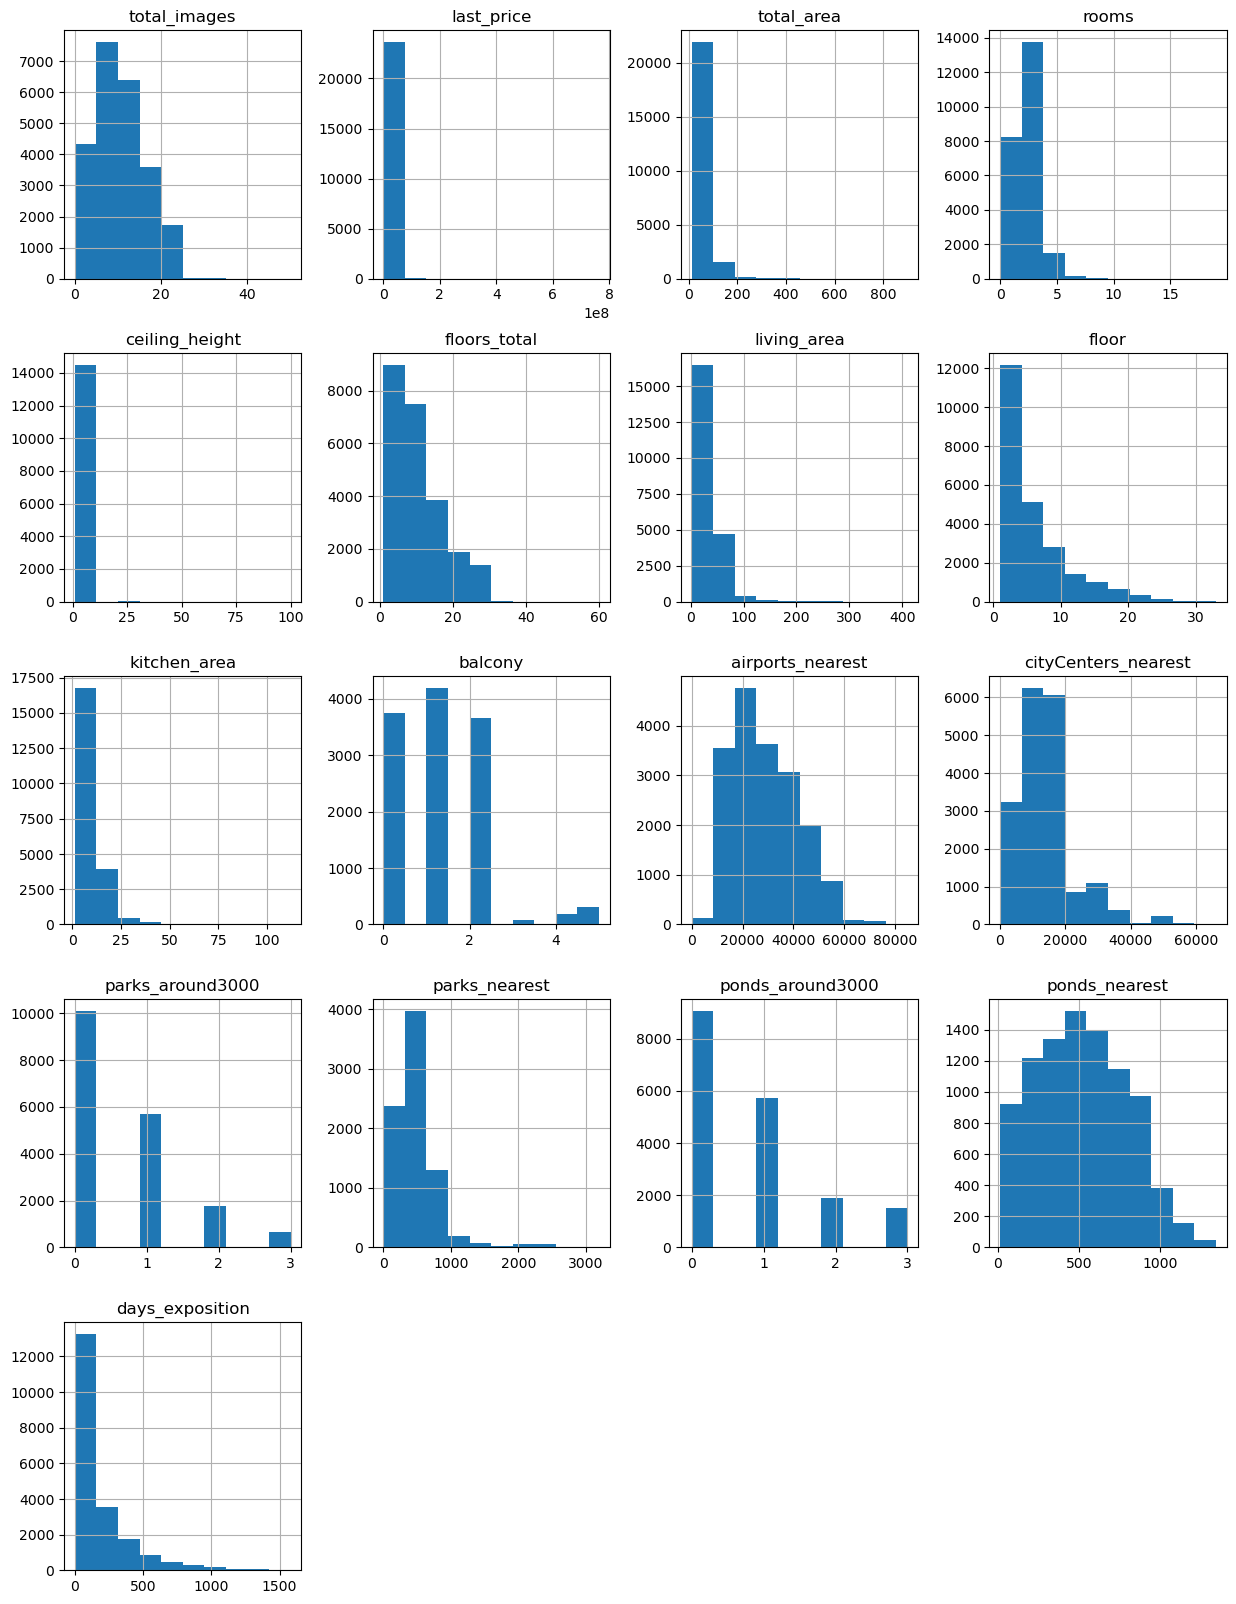

In [126]:
data.hist(figsize=(15, 20));

Ознакомились с данными(названия колонок), их типом. Видим, что в некоторых колонках есть пропуски. Гистограммы пока что не очень то информативны, нужно предобработать данные

## Предобработка данных

### Работа с пропущенными значениями

Смотрим, где у нас имеются пропущенные значения

In [127]:
data.isna().sum()

total_images                0
last_price                  0
total_area                  0
first_day_exposition        0
rooms                       0
ceiling_height           9195
floors_total               86
living_area              1903
floor                       0
is_apartment            20924
studio                      0
open_plan                   0
kitchen_area             2278
balcony                 11519
locality_name              49
airports_nearest         5542
cityCenters_nearest      5519
parks_around3000         5518
parks_nearest           15620
ponds_around3000         5518
ponds_nearest           14589
days_exposition          3181
dtype: int64

 `ceiling_height`

Не все пользователи могут знать высоту потолка своих объектов, вероятно, с этим и связаны пропуски.  
Большинство домов являются типовыми и похожими, поэтому заполним пропуски медианным значением для каждого n-этажного типа дома.
При этом нам понадобится значение `floors_total`, где тоже есть пропуски. Но, их немного, и такие строки мы удалим. Если взять значение для домов определенной этажности не получилось, возьмем общее медианное значение 

In [128]:
data = data.dropna(subset=['floors_total'])

data['ceiling_height'] = data['ceiling_height'].fillna(
    data.groupby('floors_total')['ceiling_height']
    .transform('median')
)
data['ceiling_height'] = data['ceiling_height'].fillna(
    value=data['ceiling_height'].median()
)
print('Нулевых значений:')
data[['floors_total', 'ceiling_height']].isna().sum()

Нулевых значений:


floors_total      0
ceiling_height    0
dtype: int64

`kitchen_area` и `living_area`

Многие собственники знают только общую площадь квартиры, отсюда и пропуски. Оставлю пустые значения


`is_apartment`

Пропуски, вероятно, означают не апартаменты. Заполню их значением *False*

In [129]:
data['is_apartment'] = data['is_apartment'].fillna(False)

`balcony`
 
 Пропуск значений - скорее всего отсутсвие балконов, заменю их на 0

In [130]:
data['balcony'] = data['balcony'].fillna(0)

`locality_name`
 
 Строк без указания населенного пункта немного, удалю их

In [131]:
data = data.dropna(subset=['locality_name'])

`airports_nearest`, `cityCenters_nearest`, `parks_nearest`, `ponds_nearest`

Пропуски появились из-за отсутсвия в населенном пункте аэропорта, парков, водоемов. Расстояние до центра города заполнить чем-то тоже не получится. Оставлю как есть

`parks_around3000`, `ponds_around3000`
 
Пропуски, скорее всего, означают отсутствие. Заменю на 0

In [132]:
cols_to_fill = ['parks_around3000', 'ponds_around3000']
data[cols_to_fill] = data[cols_to_fill].fillna(0)

`days_exposition`
 
Врзможно, пропуски возникли у объявлений в черновиках, оставлю как есть 

После обработки пропусков, получился такой датафрейм

In [133]:
print('Пропусков:')
data.reset_index(drop=True).isna().sum()

Пропусков:


total_images                0
last_price                  0
total_area                  0
first_day_exposition        0
rooms                       0
ceiling_height              0
floors_total                0
living_area              1865
floor                       0
is_apartment                0
studio                      0
open_plan                   0
kitchen_area             2222
balcony                     0
locality_name               0
airports_nearest         5524
cityCenters_nearest      5501
parks_around3000            0
parks_nearest           15535
ponds_around3000            0
ponds_nearest           14529
days_exposition          3171
dtype: int64

### Изменение типов данных

In [134]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 23565 entries, 0 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   total_images          23565 non-null  int64  
 1   last_price            23565 non-null  float64
 2   total_area            23565 non-null  float64
 3   first_day_exposition  23565 non-null  object 
 4   rooms                 23565 non-null  int64  
 5   ceiling_height        23565 non-null  float64
 6   floors_total          23565 non-null  float64
 7   living_area           21700 non-null  float64
 8   floor                 23565 non-null  int64  
 9   is_apartment          23565 non-null  bool   
 10  studio                23565 non-null  bool   
 11  open_plan             23565 non-null  bool   
 12  kitchen_area          21343 non-null  float64
 13  balcony               23565 non-null  float64
 14  locality_name         23565 non-null  object 
 15  airports_nearest      18

Сменю тип данных:

- `first_day_exposition` на date для удобства работы
- `floors_total` на целочисленный
- `balcony` на целочисленный
- `parks_around3000` и `ponds_around3000` на целочисленный
- `last_price` для удобства буду выводить в миллионах

In [135]:
data['first_day_exposition'] = pd.to_datetime(
    data['first_day_exposition'], format='%Y-%m-%dT%H:%M:%S'
)
cols_to_int = [
    'floors_total', 'balcony', 
    'parks_around3000', 'ponds_around3000'
]
data[cols_to_int] = data[cols_to_int].astype(int)
data['last_price'] = data['last_price'] / 1e+06

### Работа с дубликатами в названиях населенных пунктов

Заменю городской поселок на поселок городского типа и букву ё на е

In [136]:
data['locality_name'] = data['locality_name'].str.replace('городской поселок','поселок городского типа')
data['locality_name'] = data['locality_name'].str.replace('ё', 'е')

### Работа с аномальными значениями

In [137]:
old_data_shape = data.shape[0]
display(data.loc[:, 'total_images':'kitchen_area'].describe())
data.loc[:, 'balcony':].describe()

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,kitchen_area
count,23565.000000,23565.000000,23565.000000,23565,23565.000000,23565.000000,23565.000000,21700.000000,23565.000000,21343.000000
mean,9.878421,6.540058,60.322824,2017-11-10 08:59:53.125398016,2.070656,2.735737,10.675875,34.454822,5.878124,10.560994
min,0.000000,0.012190,12.000000,2014-11-27 00:00:00,0.000000,1.000000,1.000000,2.000000,1.000000,1.300000
25%,6.000000,3.400000,40.000000,2017-05-15 00:00:00,1.000000,2.550000,5.000000,18.600000,2.000000,7.000000
50%,9.000000,4.646000,52.000000,2017-12-12 00:00:00,2.000000,2.650000,9.000000,30.000000,4.000000,9.100000
75%,14.000000,6.790000,69.700000,2018-08-26 00:00:00,3.000000,2.750000,16.000000,42.300000,8.000000,12.000000
max,50.000000,763.000000,900.000000,2019-05-03 00:00:00,19.000000,100.000000,60.000000,409.700000,33.000000,112.000000
std,5.681156,10.910935,35.657060,NaN,1.078591,0.996999,6.594823,22.045359,4.871485,5.900630


,balcony,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
count,23565.000000,18041.000000,18064.000000,23565.000000,8030.000000,23565.000000,9036.000000,20394.000000
mean,0.593677,28797.082701,14192.656056,0.468831,490.580448,0.589900,518.289509,180.741395
std,0.960660,12632.499735,8613.348153,0.748403,341.572956,0.883966,278.009558,219.732782
min,0.000000,0.000000,181.000000,0.000000,1.000000,0.000000,13.000000,1.000000
25%,0.000000,18565.000000,9238.000000,0.000000,288.000000,0.000000,293.000000,45.000000
50%,0.000000,26757.000000,13096.500000,0.000000,455.000000,0.000000,503.000000,95.000000
75%,1.000000,37273.000000,16285.000000,1.000000,612.000000,1.000000,730.000000,231.000000
max,5.000000,84869.000000,65968.000000,3.000000,3190.000000,3.000000,1344.000000,1580.000000


Сначала оценим данные, которые заполнялись пользователями. Судя по стандартному отклонению и максимальным значениям нужно проверить `total_area`, `last_price`, `rooms` и `ceiling_height`

`last_price`

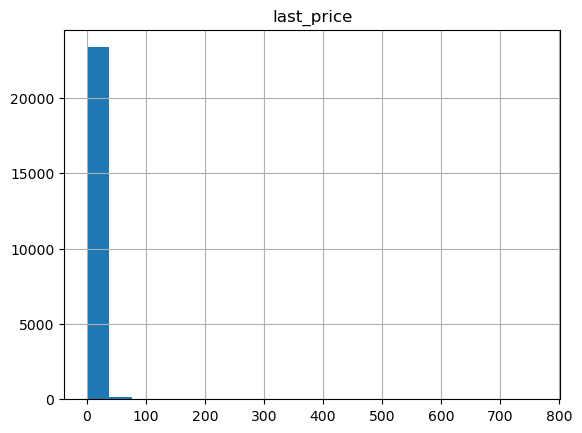

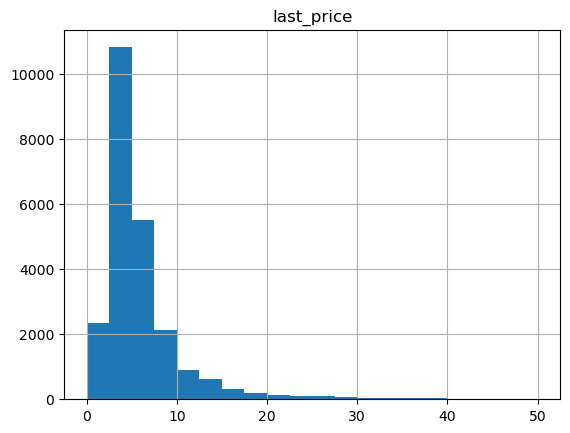

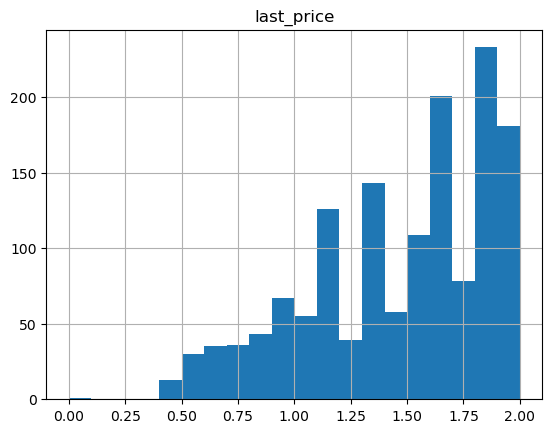

In [138]:
data.hist(column='last_price', bins=20);
data.hist(column='last_price', bins=20, range=(0, 50));
data.hist(column='last_price', bins=20, range=(0, 2));

Видим, что есть выбросы в виде очень больших значений. Проверим еще очень дешевые квартиры

In [139]:
print('Too low:', data.query('last_price < 0.8')['last_price'].count())
print('Too expensive:', data.query('last_price > 30')['last_price'].count())

Too low: 115
Too expensive: 315


Уберем аномальные значения

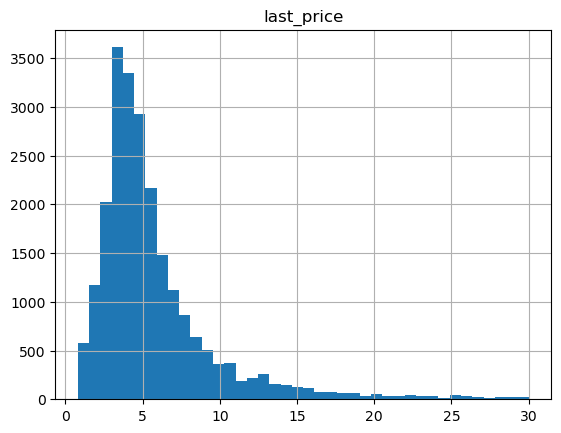

In [140]:
data = data.query('(last_price >= 0.8) & (last_price <= 30)')
data.hist(column='last_price', bins=40);

`total_area`

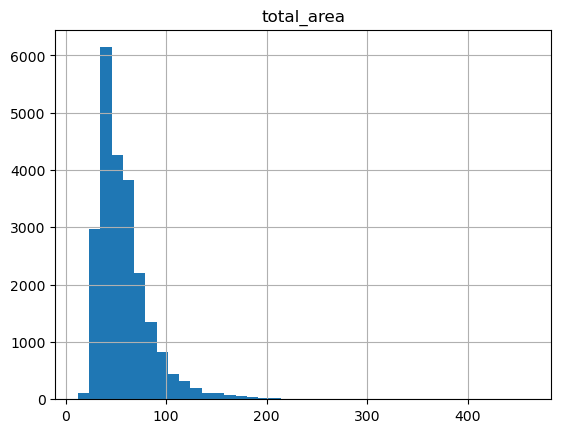

In [141]:
data.hist(column='total_area', bins=40);

In [142]:
print('Too big:', data.query('total_area > 150')['total_area'].count())

Too big: 346


Уберем квартиры со слишком большой площадью, возможно, это помещения коммерческого назначения

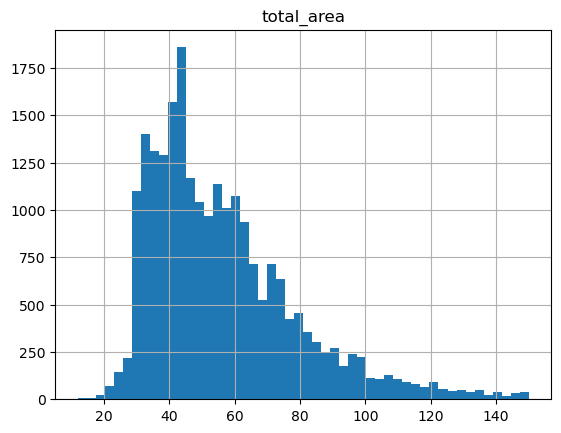

In [143]:
data = data.query('total_area <= 150')
data.hist(column='total_area', bins=50);

4. `rooms`

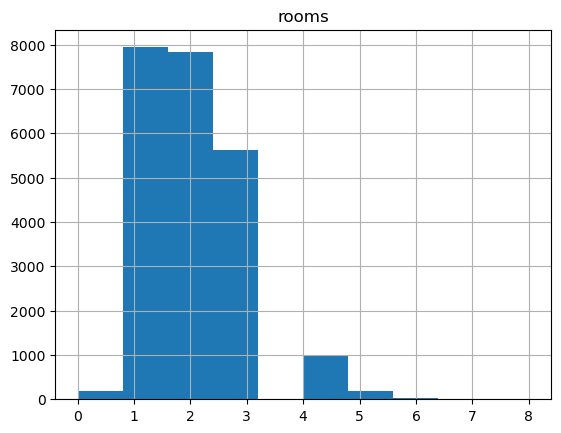

In [144]:
data.hist(column='rooms');

In [145]:
print('Too many rooms:', data.query('rooms > 6')['rooms'].count())
print('Has no rooms:', data.query('rooms < 1')['rooms'].count())

Too many rooms: 9
Has no rooms: 193


Уберем объекты, у которых слишком много комнат. У квартир без комнат изменим значение на 1, если это студия или есть открытая планировка

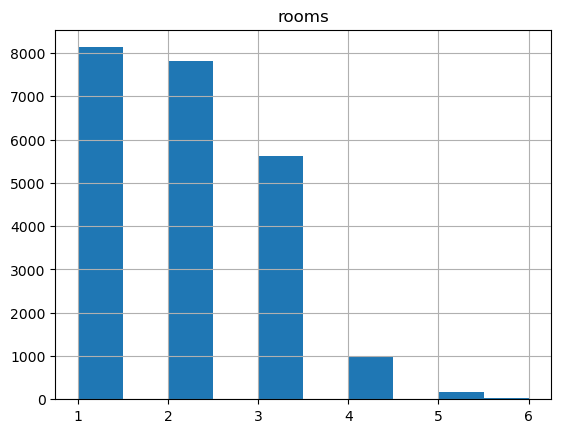

In [146]:
data = data.query('rooms <= 6')
data.loc[(data['rooms'] == 0) & ((data['studio']) | (data['open_plan'])), 'rooms'] = 1
data.hist(column='rooms');

5. `ceiling_height` 

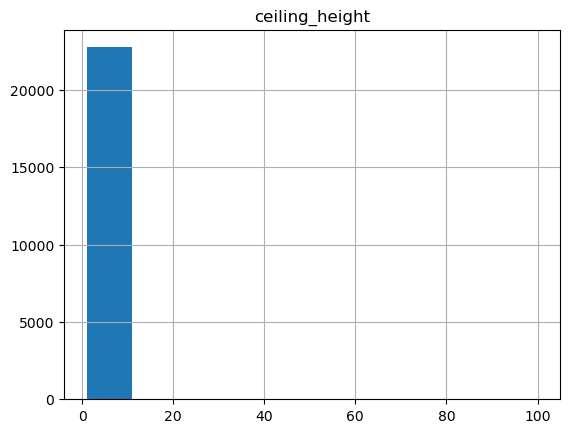

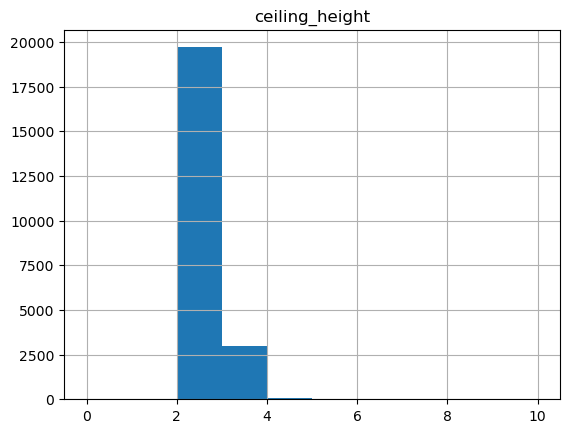

In [147]:
data.hist(column='ceiling_height')
data.hist(column='ceiling_height', range=(0, 10));

Предположим, что значения больше 10м это опечатка

Too low: 19
Too high: 34


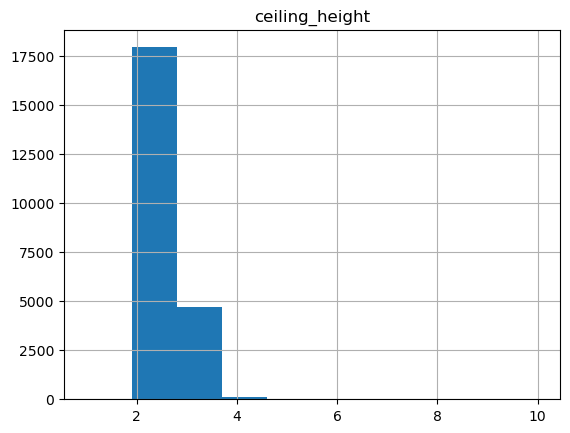

In [148]:
data.loc[(data['ceiling_height'] >= 10), 'ceiling_height'] = data['ceiling_height'] / 10
print('Too low:', data.query('ceiling_height < 2.25')['ceiling_height'].count())
print('Too high:', data.query('ceiling_height > 4')['ceiling_height'].count())
data.hist(column='ceiling_height');

И уберем выбивающиеся значения

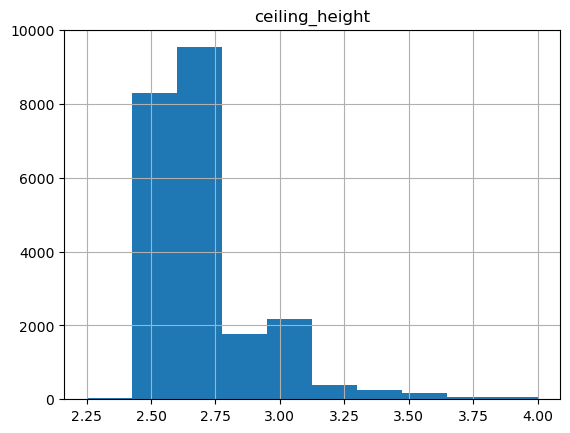

In [149]:
data = data.query('(ceiling_height >= 2.25) & (ceiling_height <= 4)')
data.hist(column='ceiling_height');

`airports_nearest` `cityCenters_nearest` `parks_around3000`	`parks_nearest`	`ponds_around3000`	`ponds_nearest`

Эти поля заполнялись автоматически, и, судя по data.describe(), данные выглядят нормальными. Единственное, у `airports_nearest` есть значение 0

Too close: 1


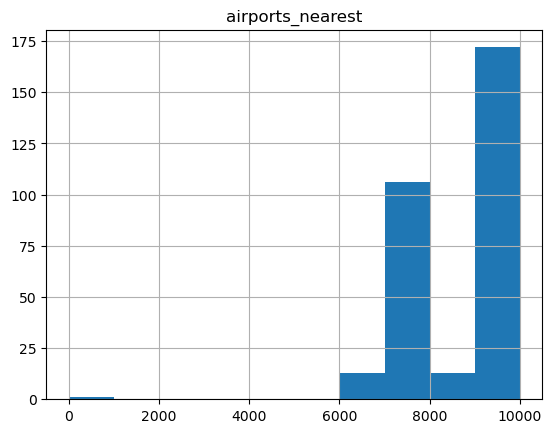

In [150]:
data.hist(column='airports_nearest', range=(0, 10000));
print('Too close:', data.query('airports_nearest < 6000')['airports_nearest'].count())

Уберем аномальное значение

In [151]:
data.drop(index=data.query('airports_nearest < 6000').index,inplace=True)

`days_exposition`

Думал, если срок объявления превышает 1-2 года - это редкость и, скорее всего, аномалия. Но, оказалось, что нет

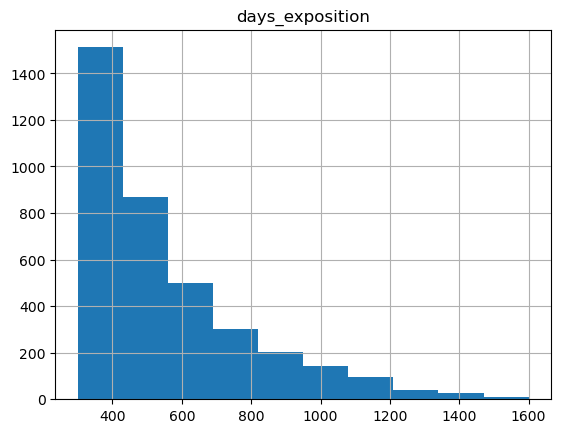

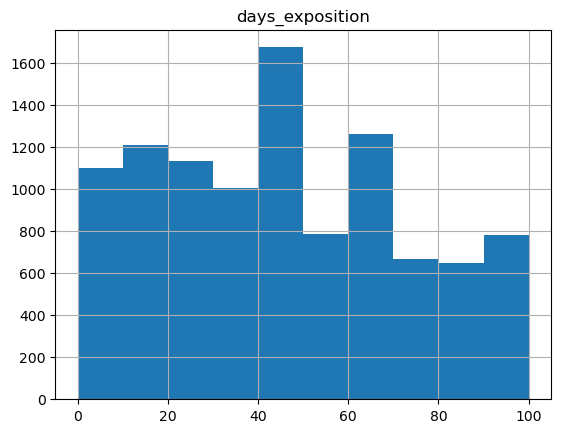

In [152]:
data.hist(column='days_exposition', range=(300, 1600))
data.hist(column='days_exposition', range=(0, 100));

И сбросим индексы, так как удаляли строки

In [153]:
data.reset_index(drop=True,inplace=True)

**Подытог**

Проверим, не потеряли ли мы слишком большой обьем данных, ведь тогда датасет сложно будет назвать репрезентативным

In [154]:
print('Оcталось данных:', "{:.1%}".format(data.shape[0] / old_data_shape))

Оcталось данных: 96.4%


Отлично, данные сохранены.

Часть данных заполнялась пользователями, а часть - автоматически, что влияет на характер отсутсвия данных или характер аномалий в данных. Часть пропусков получилось восстановить, например, количество балконов: пропуск здесь означал отсутвие и был заменен нулем. Были значения, заполнить которые нельзя, например, название населенного пункта. Но и оставить пропуск не выйдет - без этого значения вся строчка с данными теряет смысл. Поэтому, такие строки были удалены, благо, что их было немного.

## Посчитайте и добавьте в таблицу новые столбцы

Цена одного квадратного метра(в тысячах)

In [155]:
data['square_price'] = data['last_price'] / data['total_area'] * 1000

День публикации обьявления

In [156]:
data['day_of_week'] = data['first_day_exposition'].dt.weekday

Месяц публикации объявления

In [157]:
data['month'] = data['first_day_exposition'].dt.month

Год публикации объявления

In [158]:
data['year'] = data['first_day_exposition'].dt.year

Тип этажа квартиры

In [159]:
data['floor_type'] = data.apply(
    lambda x: 'первый' if x['floor'] == 1 
    else ('последний' if x['floor'] == x['floors_total'] 
    else 'другой'), axis=1)

Растояние в км до центра города

In [160]:
data['cityCenters_nearest_km'] = round(data['cityCenters_nearest'] / 1000)

## Проведите исследовательский анализ данных

### Изучение отдельных параметров

**Общая площадь**

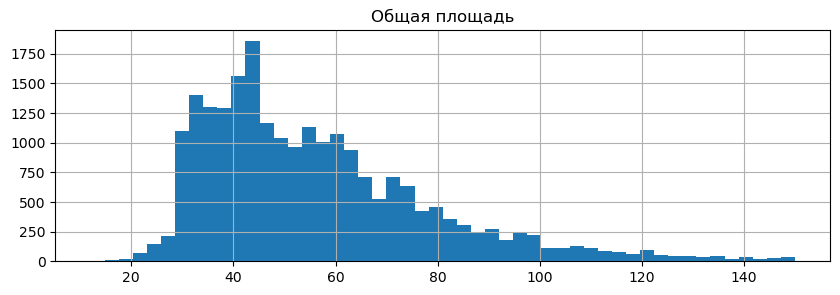

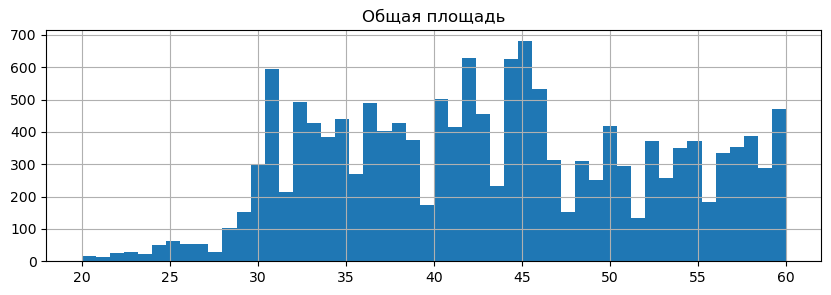

In [161]:
data.hist(column='total_area', bins=50, figsize=(10, 3))
plt.title('Общая площадь')
data.hist(column='total_area', bins=50, range=(20, 60), figsize=(10, 3))
plt.title('Общая площадь')
plt.show()

Видим, что график смещен вправо: большой недвижимость может быть, а вот слишком маленькой нет.
А еще, можно предположить, что недвижимость менее 30кв. м. не так популярна на рынке

**Жилая площадь**

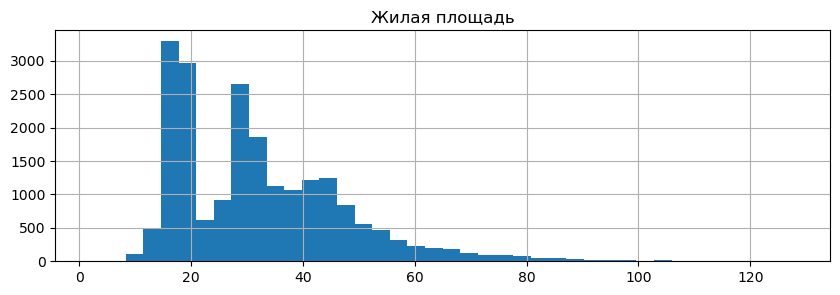

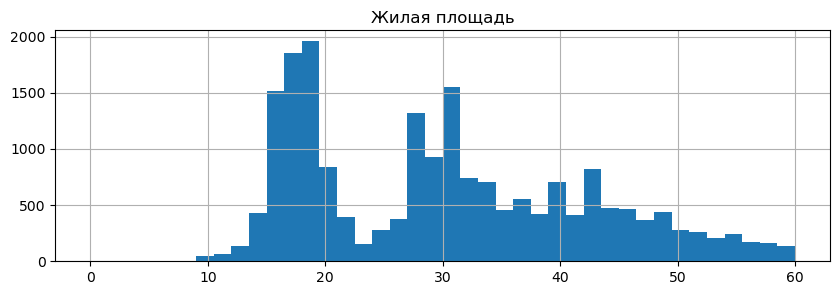

In [162]:
data.hist(column='living_area', bins=40, figsize=(10, 3))
plt.title('Жилая площадь')
data.hist(column='living_area', bins=40, range=(0, 60), figsize=(10, 3))
plt.title('Жилая площадь')
plt.show()

График неравномерный, есть несколько пиков. Думаю, это связано с типовой застройкой недвижимости в СССР

**Площадь кухни**

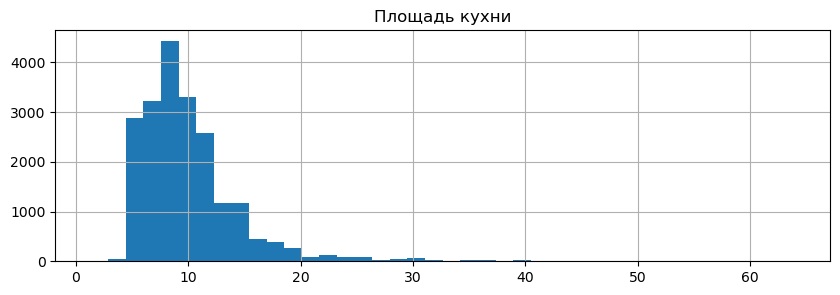

In [163]:
data.hist(column='kitchen_area', bins=40, figsize=(10, 3))
plt.title('Площадь кухни')
plt.show()

График смещен вправо - большие кухни есть, хоть их и мало, а вот меньше 5 кв. м. почти нет. Скорее всего, потому что это студии, и размер кухни предпочитают не указывать отдельно

**Цена объекта**

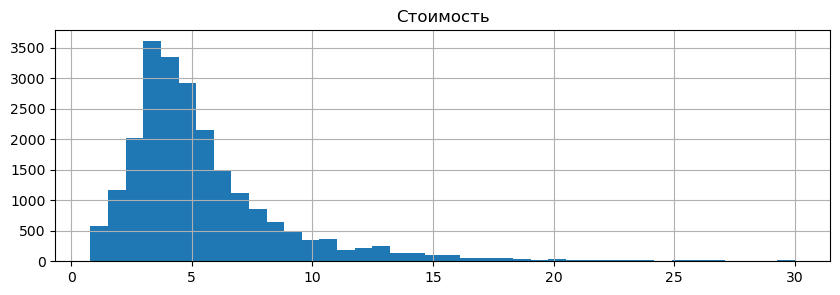

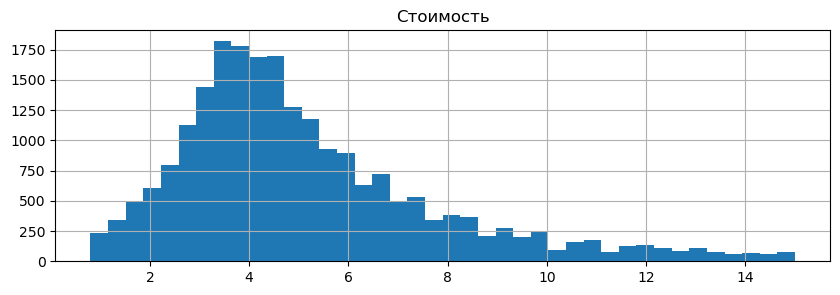

In [164]:
data.hist(column='last_price', bins=40, figsize=(10, 3))
plt.title('Стоимость')
data.hist(column='last_price', bins=40, range=(0.8, 15), figsize=(10, 3))
plt.title('Стоимость')
plt.show()

График смещен вправо: недвижимости дешевле 2млн почти нет

**Количество комнат**

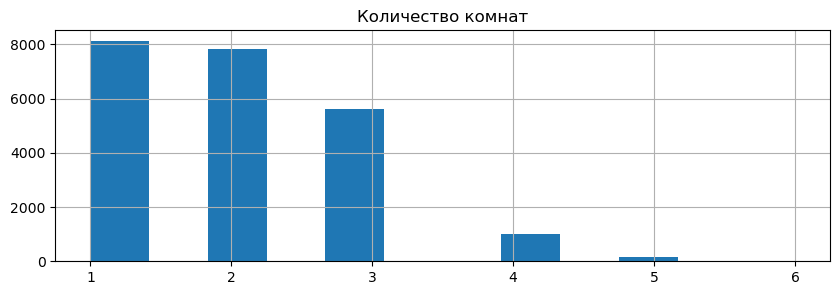

In [165]:
data.hist(column='rooms', bins=12, figsize=(10, 3))
plt.title('Количество комнат')
plt.show()

Популярнее всего на рынке однокомнатные, двухкомнатные и трехкомнатные квартиры

**Высота потолков**

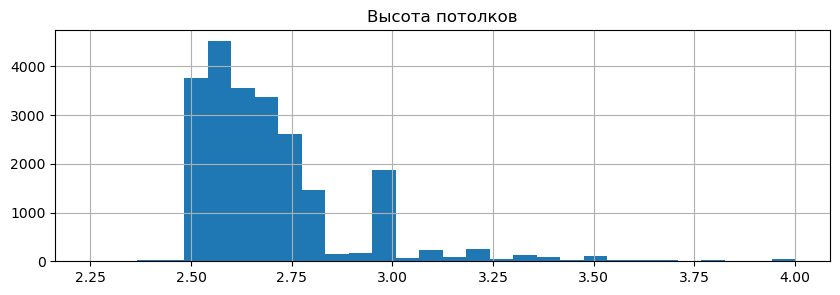

In [166]:
data.hist(column='ceiling_height', bins=30, figsize=(10, 3))
plt.title('Высота потолков')
plt.show()

Неравномерность и пики - следствие типовой застройки. Больше всего квартир с потолками 2,5м и 3м

**Этаж квартиры**

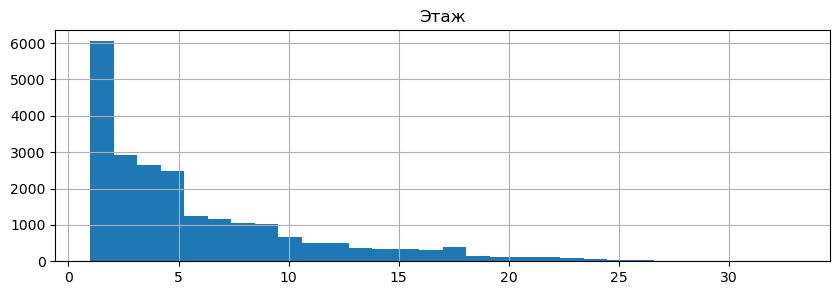

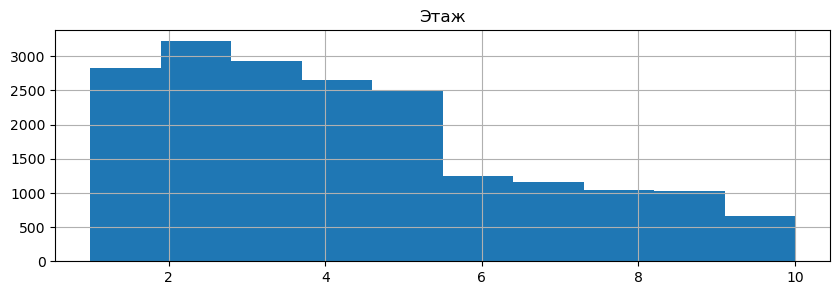

In [167]:
data.hist(column='floor', bins=30, figsize=(10, 3))
plt.title('Этаж')
data.hist(column='floor', range=(1, 10), figsize=(10, 3))
plt.title('Этаж')
plt.show()

Больше всего квартир с 1 по 5 этаж, потому что пятиэтажек больше, чем девятиэтажек. А небоскребов еще меньше

**Тип этажа квартиры**

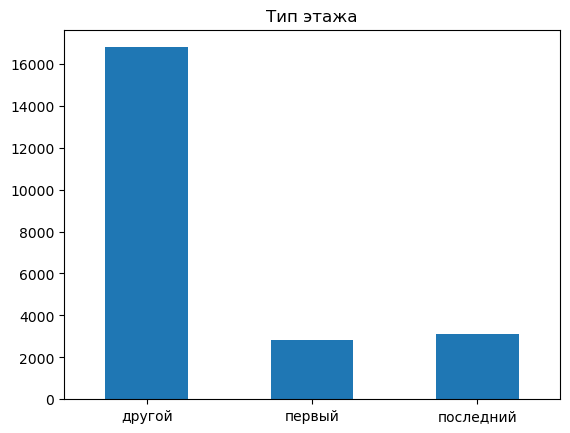

In [168]:
data.groupby(by='floor_type')['floor_type'].count().plot(kind='bar', xlabel='')
plt.title('Тип этажа')
plt.xticks(rotation=0)
plt.show()

Первых и последних этажей почти равное количество, что логично - они на разных концах распределения

**Общее количество этажей в доме**

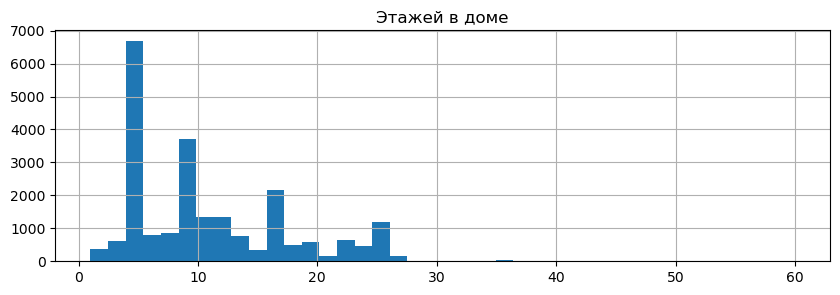

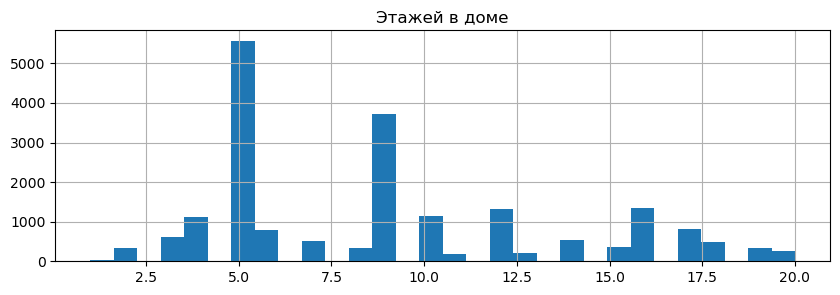

In [169]:
data.hist('floors_total', bins=40, figsize=(10, 3))
plt.title('Этажей в доме')
data.hist('floors_total', bins=30, range=(1, 20), figsize=(10, 3))
plt.title('Этажей в доме')
plt.show()

Видим, что пятиэтажек и девятиэтажек больше всего на рынке

**Расстояние до центра города в метрах**

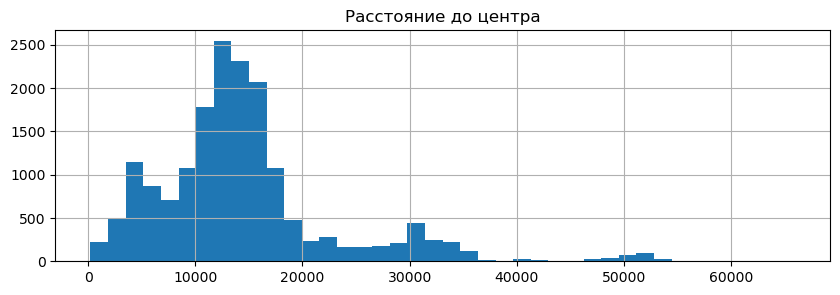

In [170]:
data.hist('cityCenters_nearest', bins=40, figsize=(10, 3))
plt.title('Расстояние до центра')
plt.show()

Пики - разные районы и пригороды Санкт-Петербурга

**Расстояние до ближайшего аэропорта**

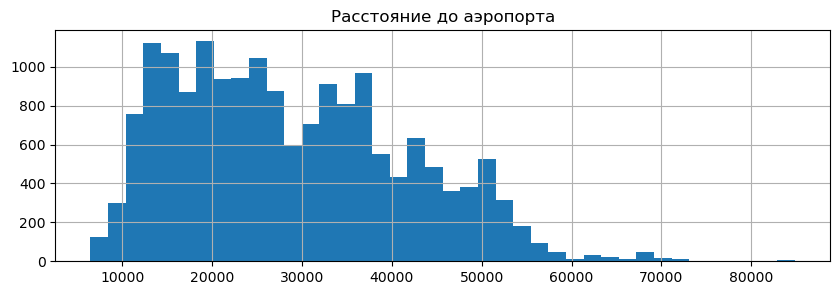

In [171]:
data.hist('airports_nearest', bins=40, figsize=(10, 3))
plt.title('Расстояние до аэропорта')
plt.show()

Можно увидеть, что в приделах 5км. от аэропорта нет жилой недвижимости

**Расстояние до ближайшего парка**

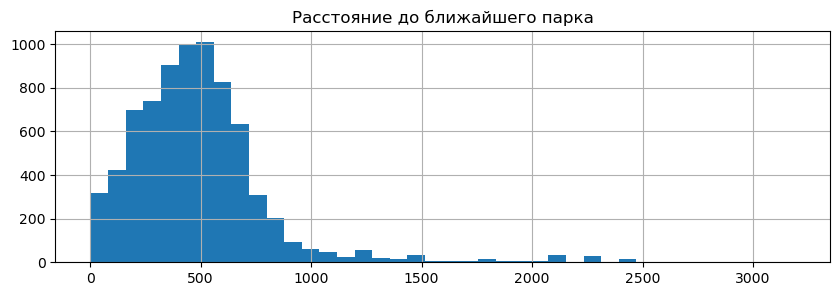

In [172]:
data.hist('parks_nearest', bins=40, figsize=(10, 3))
plt.title('Расстояние до ближайшего парка')
plt.show()

У большинства квартир есть парк в пределах 1км

**Месяц публикации объявления**

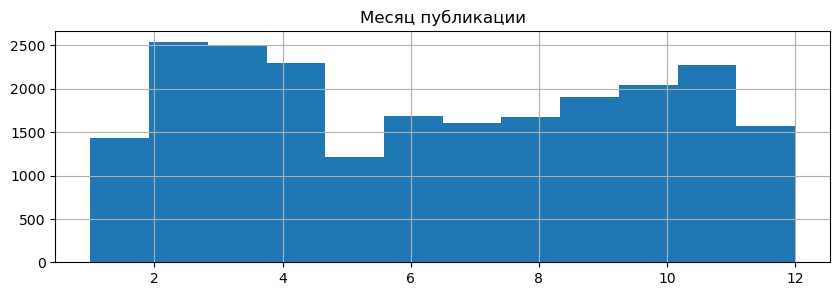

In [173]:
data.hist('month', bins=12, figsize=(10, 3))
plt.title('Месяц публикации')
plt.show()

Активнее всего рынок недвижимости с февраля по апрель. В мае он испытывает сильный спад и плавный рост до ноября. Декабрь и январь - опять спокойные месяцы

**День публикации объявления**

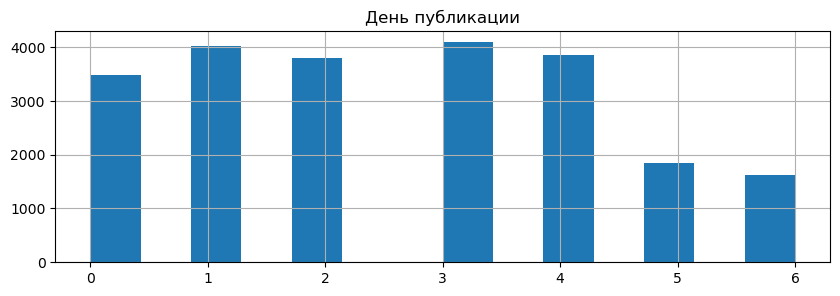

In [174]:
data.hist('day_of_week', bins=14, figsize=(10, 3))
plt.title('День публикации')
plt.show()

Активнее всего рынок недвижимости в будние дни, небольшие пики во вторник и четверг. В выходные активность снижена

### Анализ скорости продажи квартир

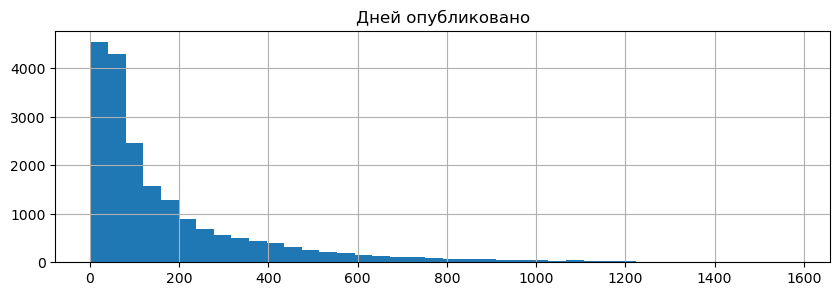

In [175]:
data.hist('days_exposition', bins=40, figsize=(10, 3))
plt.title('Дней опубликовано')
plt.show()

По такой гистограмме сложно что-то сказать, узнаем среднее и медианное количество дней продажи

In [176]:
print('Mean value:', data['days_exposition'].mean())
print('Median value:', data['days_exposition'].median())

Mean value: 177.81253163275636
Median value: 93.0


Среднее значение искажено в большую сторону, это происходит из-за аномально долгих объявлений, размещеных несколько лет. Медианное значение больше похоже на действительность

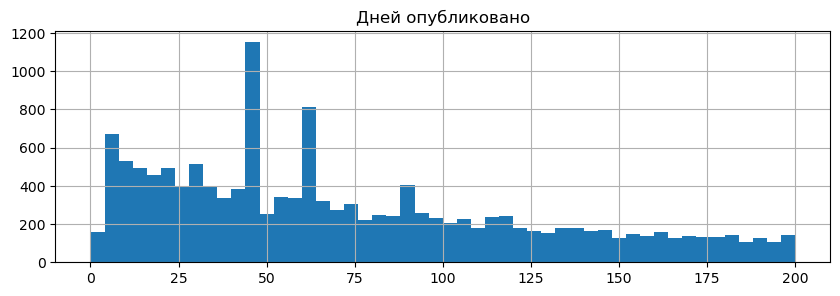

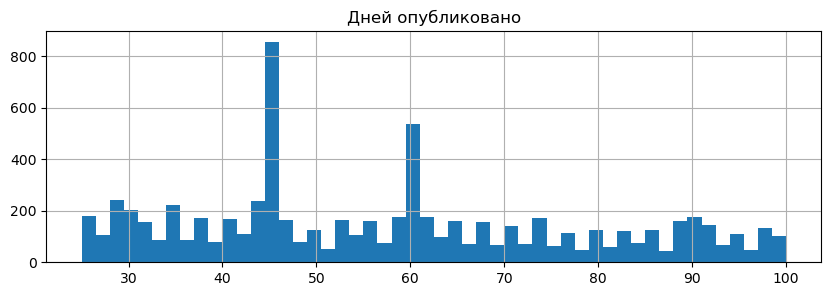

In [177]:
data.hist('days_exposition', bins=50, range=(0, 200), figsize=(10, 3))
plt.title('Дней опубликовано')
data.hist('days_exposition', bins=50, range=(25, 100), figsize=(10, 3))
plt.title('Дней опубликовано')
plt.show()

Я бы посчитал срок до 50 дней - квартира продалась быстро, срок свыше 150 дней - квартира продается долго
Есть аномально большие пики в 45 и 60 дней, предположу, что в этот срок архивируются/снимаются неактивные объявления

### Влияние различных факторов на стоимость объекта

**Влияние общей площади на стоимость объекта**

Correlation: 0.7573955475130026


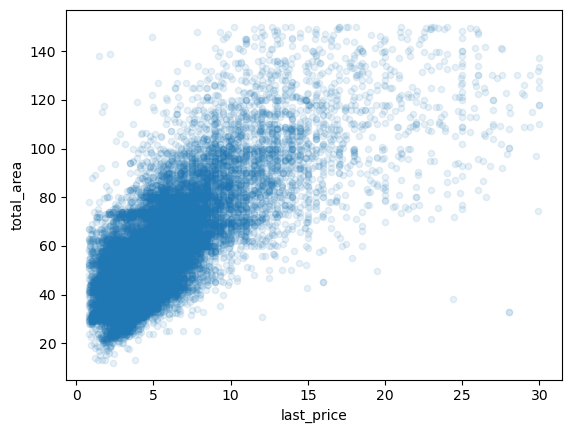

In [178]:
data.plot(x='last_price', y='total_area', kind='scatter', alpha=0.1)
print('Correlation:', data['last_price'].corr(data['total_area']))

Площадь объекта оказывает значительное влияние на его стоимость. Особенно сильно это проявляется у объектов до 100кв. м., дальше усиливается влияние других факторов

**Влияние жилой площади на стоимость объекта**

Correlation: 0.630974637749893


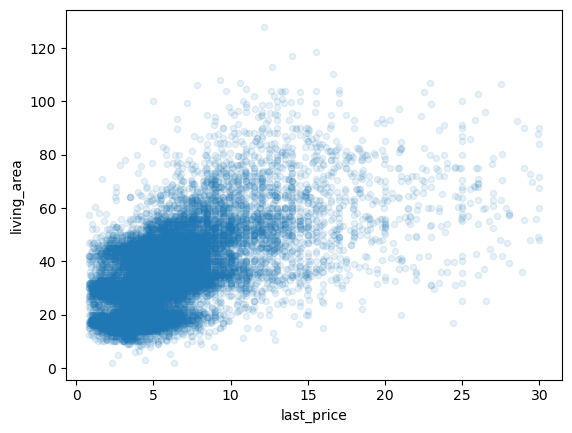

In [179]:
data.plot(x='last_price', y='living_area', kind='scatter', alpha=0.1)
print('Correlation:', data['last_price'].corr(data['living_area']))

Жилая площадь уже чуть слабее влияет на стоимость объекта

**Влияние площади кухни на стоимость объекта**

Correlation: 0.5819290063650849


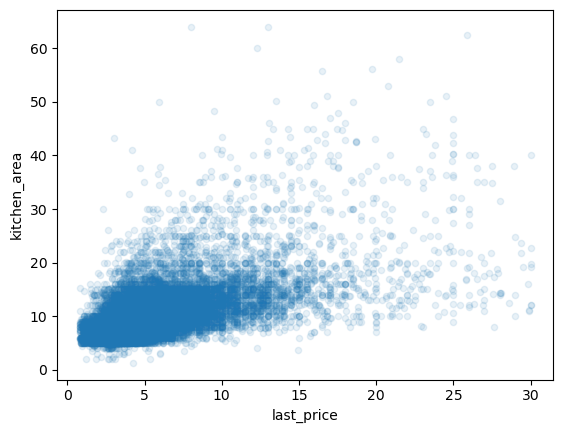

In [180]:
data.plot(x='last_price', y='kitchen_area', kind='scatter', alpha=0.1)
print('Correlation:', data['last_price'].corr(data['kitchen_area']))

Видим, что на цену сильно влияют кухни размером до 20кв. м. А вот дальше связи уже почти нет

**Влияние количества комнат на стоимость объекта**

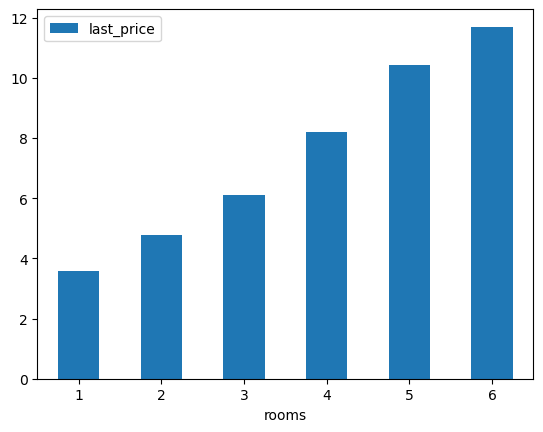

In [181]:
data.pivot_table(
    index='rooms', values='last_price', aggfunc='median').plot(kind='bar')
plt.xticks(rotation=0)
plt.show()

Связь линейная - чем больше комнат, тем дороже объект

**Влияние типа этажа на стоимость объекта**

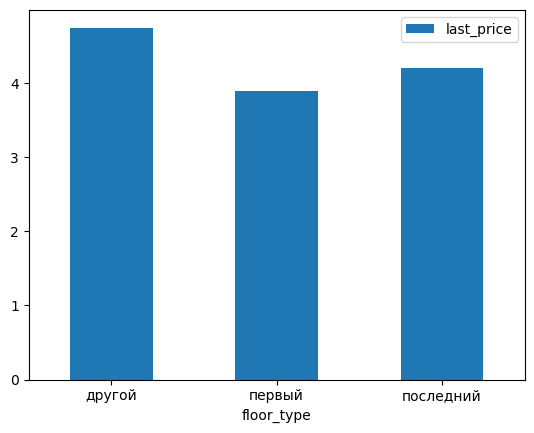

In [182]:
data.pivot_table(
    index='floor_type', values='last_price', aggfunc='median').plot(kind='bar')
plt.xticks(rotation=0)
plt.show()

Тип этажа никак не влияет на стоимость объекта

**Влияние даты размещения на стоимость объекта**

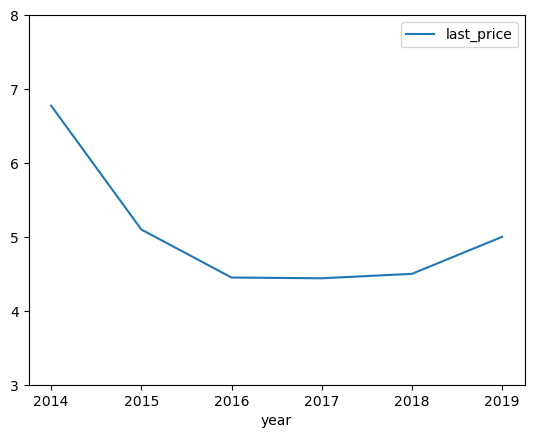

In [183]:
data.pivot_table(
    index='year', values='last_price', aggfunc='median').plot(kind='line')
plt.ylim(3, 8)
plt.xticks(rotation=0)
plt.show()

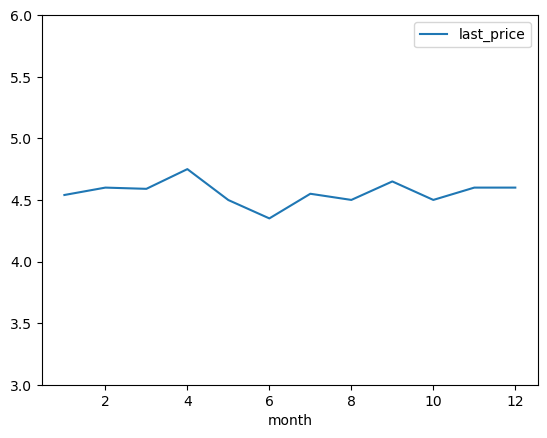

In [184]:
data.pivot_table(
    index='month', values='last_price', aggfunc='median').plot(kind='line')
plt.ylim(3, 6)
plt.xticks(rotation=0)
plt.show()

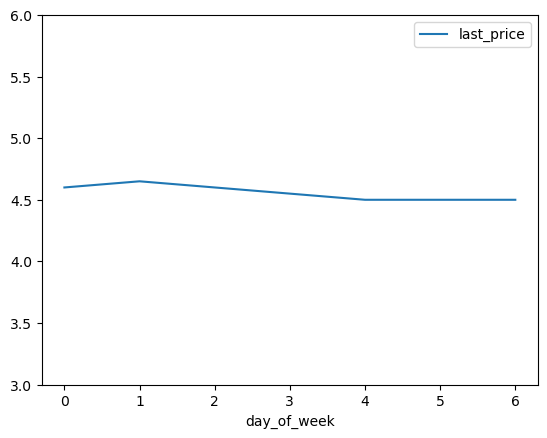

In [185]:
data.pivot_table(
    index='day_of_week', values='last_price', aggfunc='median').plot(kind='line')
plt.ylim(3, 6)
plt.xticks(rotation=0)
plt.show()

Судя по графикам, с 2014 года по 2016 рынок недвижимости испытывал падение. Затем, стагнацию до 2018, и, после рост.

В пределах одного года средняя цена объектов варьируется в пределах полу миллиона. А день недели никак не влияет на стоимость недвижимости

**Итог**

Больше всего на стоимость объекта влияет его общая площадь, затем жилая площадь и чуть меньше площадь кухни. Но это применимо для объектов в среднем до 100кв. м., дальше связь не такая сильная

Выяснили, что в период с 2014 по 2019 на рынке было падение и рост

### Анализ цены квадратного метра в топ 10 населенных пунктах по количеству объявлений

Узнаем 10 населенных пунктов, в которых опубликовано больше всего объявлений

In [186]:
top10_locs = data['locality_name'].value_counts().head(10).index.tolist()
top10_locs

['Санкт-Петербург',
 'поселок Мурино',
 'поселок Шушары',
 'Всеволожск',
 'Пушкин',
 'Колпино',
 'поселок Парголово',
 'Гатчина',
 'деревня Кудрово',
 'Выборг']

Цену одного квадратного метра(в тысячах) для каждого объекта мы расчитали в п. 3, осталось узнать среднее значение для каждого населенного пункта

In [187]:
top10_locs_table = data.query('locality_name in @top10_locs')
top10_locs_table = top10_locs_table.pivot_table(
    index='locality_name', values='square_price', aggfunc='median')
top10_locs_table['square_price'].sort_values(ascending=False).apply("{:.1f}".format)

locality_name
Санкт-Петербург      104.1
Пушкин                99.7
деревня Кудрово       91.9
поселок Парголово     91.8
поселок Мурино        86.1
поселок Шушары        76.8
Колпино               74.7
Гатчина               67.8
Всеволожск            65.8
Выборг                58.4
Name: square_price, dtype: object

Среди 10 самых популярных населенных пунктов самая высокая стоимость одного квадратного метра оказалась в Санкт-Петербурге. А самая низкая - в Выборге

### Влияние расстояния до центра города на стоимость объекта в Санкт-Петербурге

Расчитаем среднюю цену объектов на различной удаленности от центра города

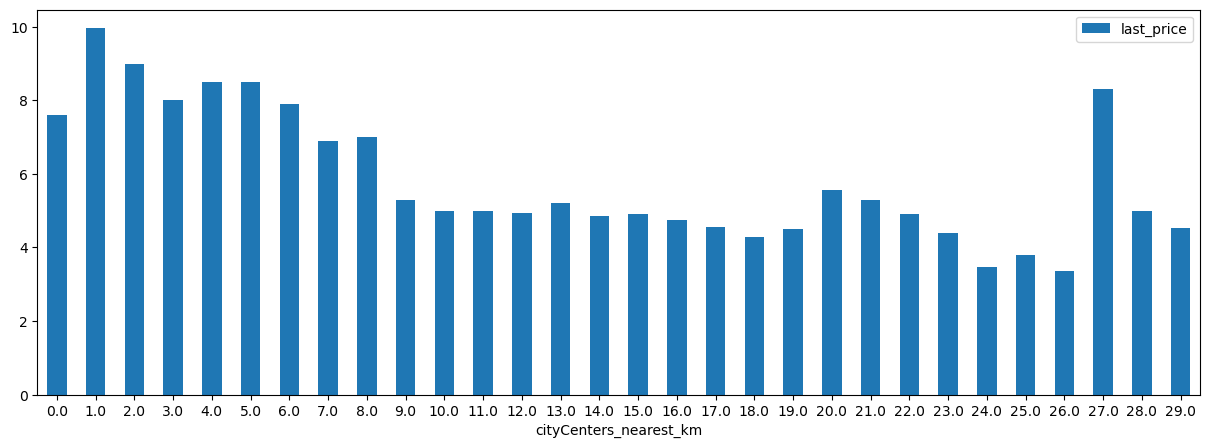

In [188]:
price_per_km = (data.query('locality_name == "Санкт-Петербург"').pivot_table(
    index='cityCenters_nearest_km', values='last_price', aggfunc='median'))
price_per_km.plot(kind='bar', figsize=(15, 5))
plt.xticks(rotation=0)
plt.show()

Видна прямая зависимость - чем дальше от центра, тем дешевле в среднем объекты. Есть пик на 27-28 километрах, предположу, что это какой-то район с дорогой недвижимостью. Граница города, думаю, проходит на 24-25 километре

## Общий вывод

Для изучения были взяты данные сервиса Яндекс.Недвижимость — архив объявлений о продаже квартир в Санкт-Петербурге и соседних населённых пунктов за несколько лет. Часть данных была заполнена пользователями, а часть автоматически.

Первым этапом работы с масивом данных была предобработка данных: нужно было обработать отсутсвующие значения и изучить аномалии(значения, которые слишком сильно выбиваются из общей массы). Часть пропусков получилось восстановить, например, количество балконов: пропуск здесь означал отсутвие и был заменен нулем. Были значения, заполнить которые нельзя, например, название населенного пункта. Но и оставить пропуск не выйдет - без этого значения вся строчка с данными теряет смысл. Поэтому, такие строки были удалены, благо, что их было немного.

Следующим этапом была работа с промежуточными значениями: цена одного квадратного метра, день публикации, тип этажи и подобные. Они нужны для следующего шага - анализа данных.

На этом этапе изучали распределение различных параметров датасета, а также их корреляцию между собой. Вот что удалось узнать:

На рынке больше всего жилья больше 30кв. м. Большинство зданий - пятиэтажки, за ними идут девятиэтажки, небоскребов на значительно меньше. Типичная высота потолков 2,5 или 3 метра. Больше всего на рынке квартир, у которых 1, 2 или 3 комнаты. Сложно найти недвижимость дешевле 2млн., зато, почти всегда в радиусе километра найдется парк. 

Выяснили, что рынок испытывал падение с 2014 по 2016 год, а с 2018 - рост. Больше всего объявлений с февраля по апрель. В мае сильный спад и плавный рост до ноября. Декабрь и январь - опять спокойные месяцы. Средний срок продажи объекта - 3 месяца. Если получилось продать быстрее двух, вам повезло - можно считать быстрой продажей. А вот если объявление опубликовано более 5 месяцев - продажа затянулась.

При формировании стоимости объектов ключевыми параметрами являются общая площадь и удаленность от центра.

При анализе десяти самых популярных населенных пунктов выяснили, что больше всего за квадратный метр придется заплатить в Санкт-Петербурге, Пушкине и Кудрово, а меньше всего - в Гатчине, Всеволожске и Выборге